In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier


data = pd.read_csv("bank.csv", sep=";")
data.head()

,age,job,marital,education,default,balance,housing_loan,Personal-loan,contact,day,month,duration,Current-campaign,pdays,Previous-campaign,poutcome,subscribed
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [2]:
data.subscribed.value_counts()

,count
subscribed,
no,4000
yes,521


In [3]:
bank_subscribed_no = data[data.subscribed == "no"]
bank_subscribed_yes = data[data.subscribed == "yes"]

upsampled = resample(bank_subscribed_yes, replace=True, n_samples=2000)

new_data = pd.concat([bank_subscribed_no, upsampled])


In [4]:
new_data = shuffle(new_data)

In [5]:
X_features = list(new_data.columns)
X_features.remove("subscribed")
X_features

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing_loan',
 'Personal-loan',
 'contact',
 'day',
 'month',
 'duration',
 'Current-campaign',
 'pdays',
 'Previous-campaign',
 'poutcome']

In [6]:
X = pd.get_dummies(new_data[X_features], drop_first=True)
Y = new_data.subscribed.map(lambda x: int(x == "yes"))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

### **Logistic Regression Model**

In [7]:
logit = LogisticRegression()
logit.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [8]:
pred_y = logit.predict(X_test)

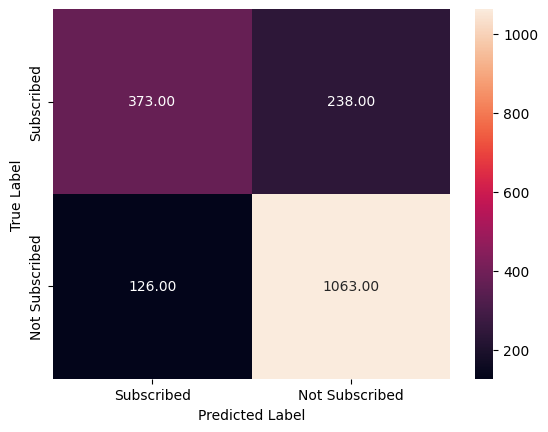

In [9]:
def draw_cm(actual, predicted):
  cm = metrics.confusion_matrix(actual, predicted, labels=[1, 0])
  sn.heatmap(cm, annot=True, fmt=".2f", xticklabels=["Subscribed", "Not Subscribed"], yticklabels=["Subscribed", "Not Subscribed"])
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")
  plt.show()

cm = draw_cm(y_test, pred_y)

In [10]:
print(metrics.classification_report(y_test, pred_y))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1189
           1       0.75      0.61      0.67       611

    accuracy                           0.80      1800
   macro avg       0.78      0.75      0.76      1800
weighted avg       0.79      0.80      0.79      1800



##### **Receiver Operating Characteristic Curve (ROC) and Area under ROC (AUC) Score**

In [11]:
predict_proba_df = pd.DataFrame(logit.predict_proba(X_test))
predict_proba_df.head()

,0,1
0,0.008132,0.991868
1,0.473067,0.526933
2,0.945212,0.054788
3,0.945985,0.054015
4,0.258185,0.741815


In [12]:
test_results = pd.DataFrame({"actual": y_test})
test_results = test_results.reset_index()
test_results["chd_1"] = predict_proba_df.iloc[:, 1:2]
test_results.head()

,index,actual,chd_1
0,509,1,0.991868
1,1309,0,0.526933
2,2063,0,0.054788
3,3581,0,0.054015
4,1166,1,0.741815


In [13]:
auc_score = metrics.roc_auc_score(test_results.actual, test_results.chd_1)
round(float(auc_score), 2)

0.86

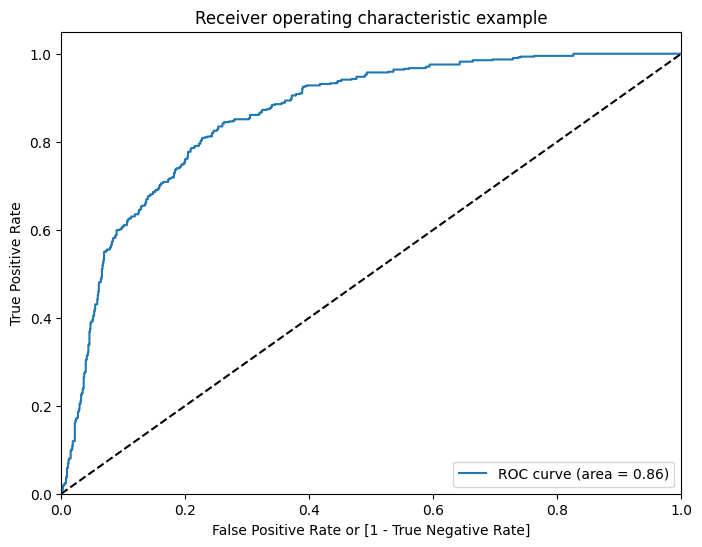

In [14]:
def draw_roc_curve(model, X_test, y_test):
  test_results = pd.DataFrame({"actual": y_test})
  test_results = test_results.reset_index()
  predict_proba_df = pd.DataFrame(logit.predict_proba(X_test))
  test_results["chd_1"] = predict_proba_df.iloc[:, 1:2]
  fpr, tpr, thresholds = metrics.roc_curve( test_results.actual,test_results.chd_1, drop_intermediate = False )
  auc_score = metrics.roc_auc_score(test_results.actual, test_results.chd_1)

  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % auc_score)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.show()

  return auc_score, fpr, tpr, thresholds
_, _, _, _ = draw_roc_curve( logit, X_test, y_test )

### **KNN Algorithms**

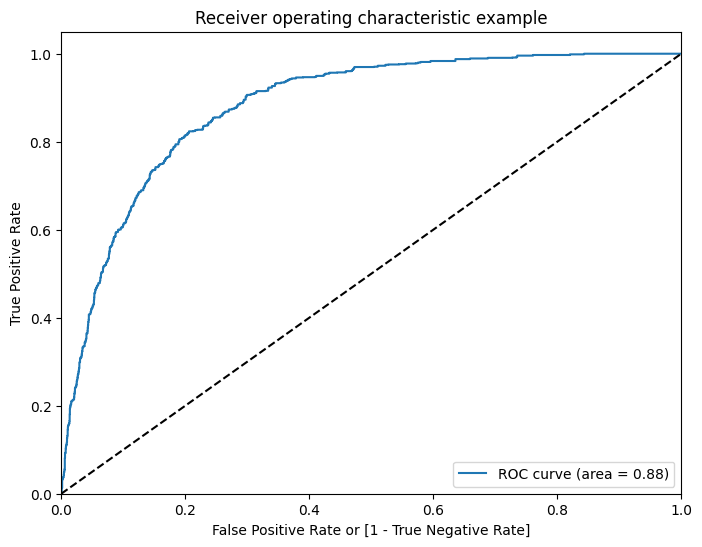

In [15]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

_, _, _, _ = draw_roc_curve( knn_clf, X_train, y_train )

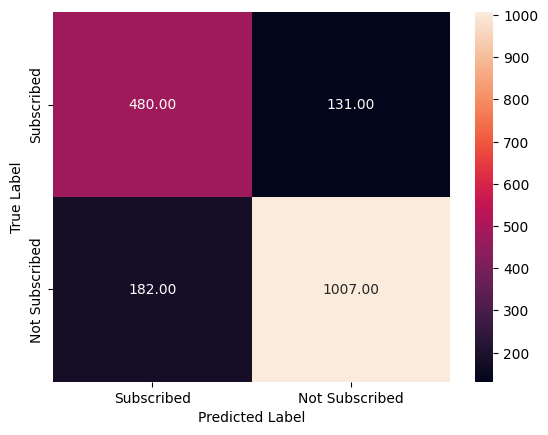

In [16]:
def draw_cm(actual, predicted):
  cm = metrics.confusion_matrix(actual, predicted, labels=[1, 0])
  sn.heatmap(cm, annot=True, fmt=".2f", xticklabels=["Subscribed", "Not Subscribed"], yticklabels=["Subscribed", "Not Subscribed"])
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")
  plt.show()

pred_y = knn_clf.predict(X_test)

draw_cm(y_test, pred_y)


In [17]:
print(metrics.classification_report(y_test, pred_y))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87      1189
           1       0.73      0.79      0.75       611

    accuracy                           0.83      1800
   macro avg       0.80      0.82      0.81      1800
weighted avg       0.83      0.83      0.83      1800



In [18]:
tuned_params = [{"n_neighbors": range(5, 10), "metric": ["canberra", "euclidean", "minkowski"]}]
clf = GridSearchCV(KNeighborsClassifier(), tuned_params, cv = 10, scoring = "roc_auc")
clf.fit(X_train, y_train)
clf.best_score_
clf.best_params_


{'metric': 'canberra', 'n_neighbors': 5}

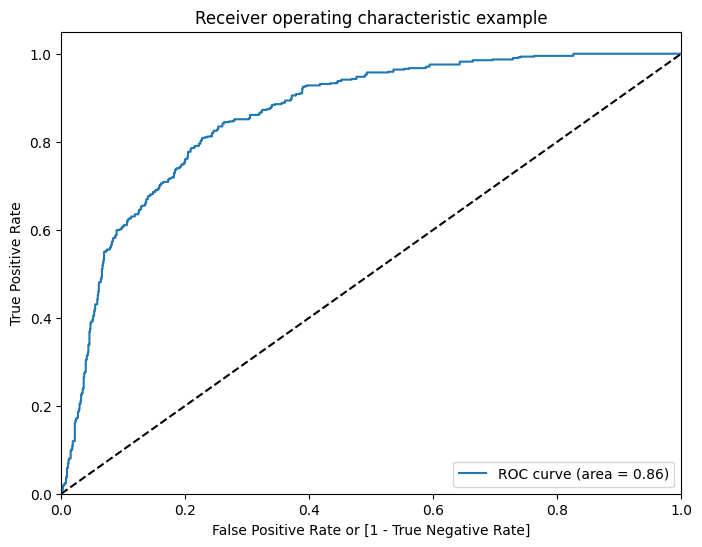

In [19]:
radm_clf = RandomForestClassifier(max_depth=10, n_estimators=10)
radm_clf.fit(X_train, y_train)

_, _, _, _ = draw_roc_curve( radm_clf, X_test, y_test )

In [20]:
print(metrics.classification_report(y_test, pred_y))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87      1189
           1       0.73      0.79      0.75       611

    accuracy                           0.83      1800
   macro avg       0.80      0.82      0.81      1800
weighted avg       0.83      0.83      0.83      1800



<Axes: xlabel='importance', ylabel='feature'>

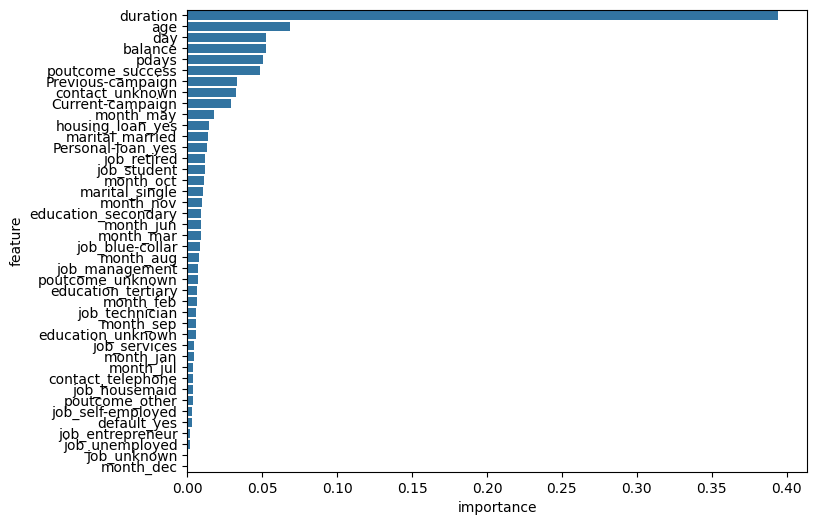

In [21]:
radm_clf.fit(X_train, y_train)
feature_rank = pd.DataFrame({"feature": X_train.columns, "importance": radm_clf.feature_importances_})
feature_rank = feature_rank.sort_values("importance", ascending=False)

plt.figure(figsize=(8, 6))
sn.barplot(data=feature_rank, x="importance", y="feature")

In [22]:
feature_rank["cumsum"] = feature_rank.importance.cumsum() * 100
feature_rank.head(10)

,feature,importance,cumsum
3,duration,0.394085,39.408515
0,age,0.068863,46.294842
2,day,0.052772,51.572036
1,balance,0.052499,56.821966
5,pdays,0.050841,61.906043
40,poutcome_success,0.048650,66.771019
6,Previous-campaign,0.033357,70.106723
27,contact_unknown,0.032671,73.373789
4,Current-campaign,0.029179,76.291673
35,month_may,0.017874,78.079097


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

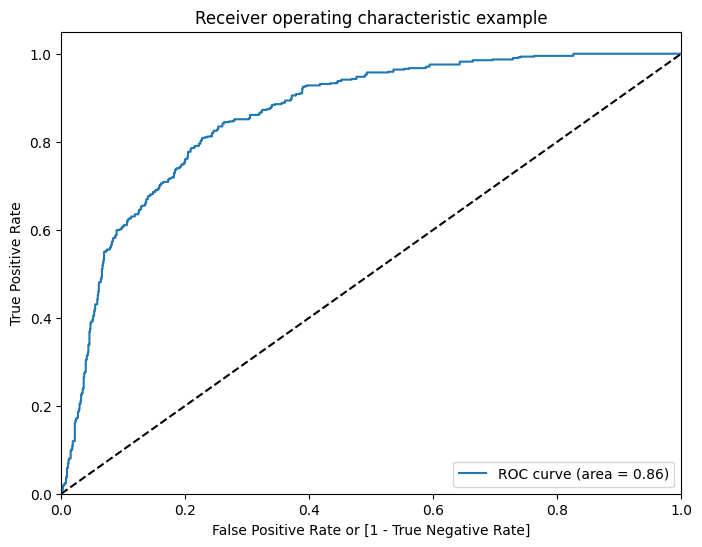

In [23]:
logreg_clf = LogisticRegression()
ada_clf = AdaBoostClassifier(logreg_clf, n_estimators=50)
ada_clf.fit(X_train, y_train)

_, _, _, _ = draw_roc_curve( ada_clf, X_test, y_test )

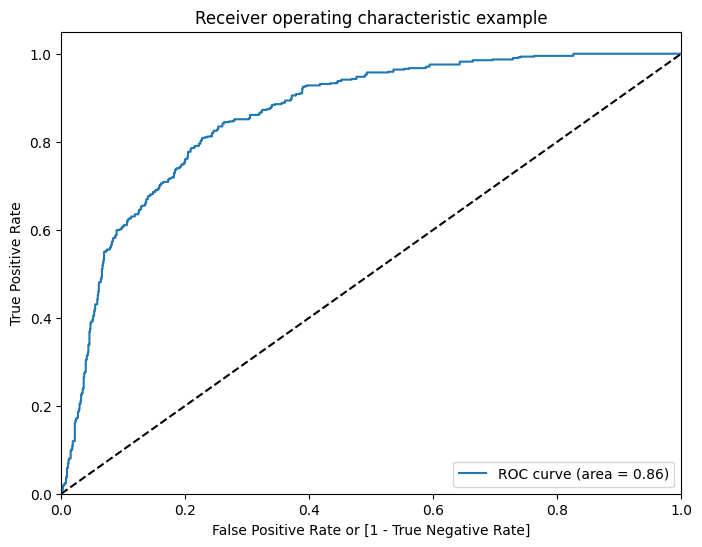

In [24]:
gboost_clf = GradientBoostingClassifier( n_estimators=500, max_depth=10)
gboost_clf.fit(X_train, y_train)
_, _, _, _ = draw_roc_curve( gboost_clf, X_test, y_test )

In [25]:
# gboost_clf = GradientBoostingClassifier( n_estimators=500, max_depth=10)
# cv_scores = cross_val_score( gboost_clf, X_train, y_train, cv = 10, scoring = "roc_auc")

# print(cv_scores)
# print('Mean Accuracy: ', np.mean(cv_scores), ' with standard deviation of:', np.std(cv_scores))


In [26]:
# gboost_clf.fit(X_train, y_train )
# pred_y = gboost_clf.predict( X_test )
# draw_cm( y_test, pred_y )


In [27]:
# print( metrics.classification_report( y_test, pred_y ) )

In [28]:
# feature_rank = pd.DataFrame( { 'feature': X_train.columns, 'importance': gboost_clf.feature_importances_ } )
# feature_rank = feature_rank.sort_values('importance', ascending = False)
# plt.figure(figsize=(8, 6))
# sn.barplot( y = 'feature', x = 'importance', data = feature_rank )
